In [3]:
import pandas as pd
from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC

folder = "../../KOI_Data/sample/"

fits_available = os.listdir(folder)
len(fits_available)

11

In [4]:
### tránsitos con nans 
#file = 'kplr001025986-20160128150956_dvt.fits'
#file = 'kplr001026032-20160128150956_dvt.fits'
file = 'kplr001161345-20160128150956_dvt.fits'

hdulist = fits.open(folder+file)
data = hdulist[1].data
lc_detrend = data.field("LC_DETREND")
lc_raw = data.field("LC_INIT")

#hdulist[1].header

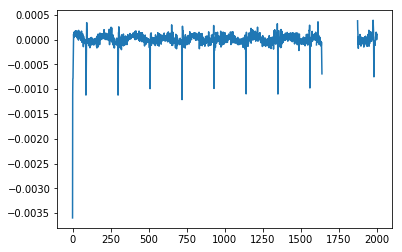

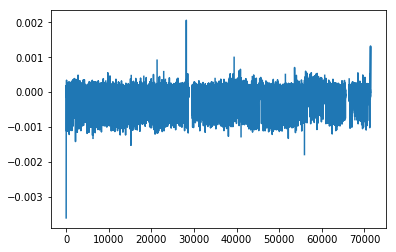

In [5]:
plt.plot(lc_detrend[:2000])
plt.show()

plt.plot(lc_detrend)
plt.show()

/home/mbugueno/anaconda3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Clean done (remove outliers iterativetly), erase 36 values


/home/mbugueno/Documentos/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in less
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)
/home/mbugueno/Documentos/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in greater
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)


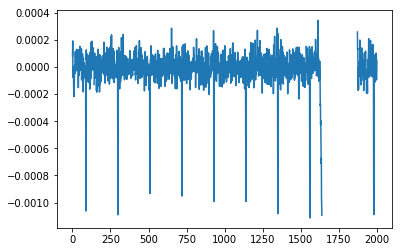

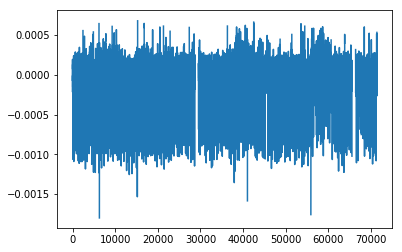

In [6]:
lc_our_detrend = clean_LC(lc_raw, plot=False)

plt.plot(lc_our_detrend[:2000])
plt.show()

plt.plot(lc_our_detrend)
plt.show()

### HMM

In [5]:
lc_init_cleaned = np.nan_to_num(lc_our_detrend[:]) #### replace nans
#con mas datos??

#Al parecer esto es Necesario para amplificar/disminuir escala
lc_init_cleaned = lc_init_cleaned/np.abs(np.min(lc_init_cleaned)) 

new_lc = np.asarray([[cur] for cur in lc_init_cleaned])

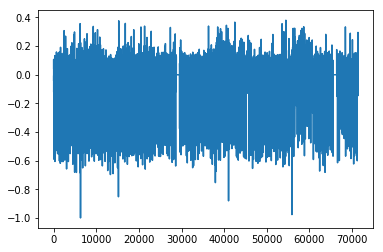

In [6]:
plt.plot(new_lc)

Log-likehood con 4  estados del conjunto de entrenamiento 134526.0058304202


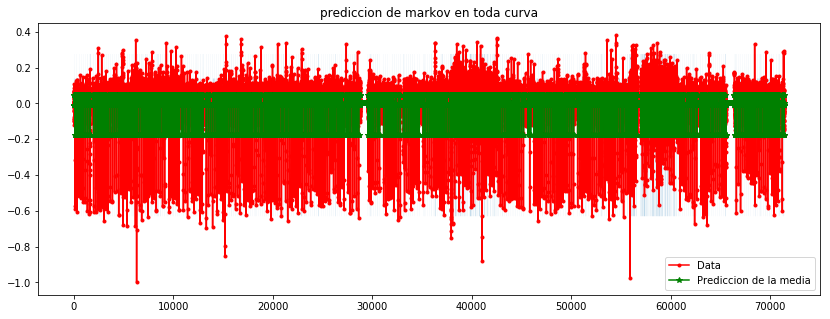

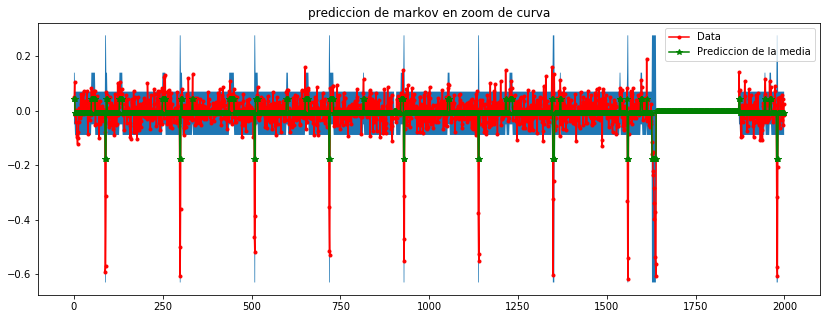

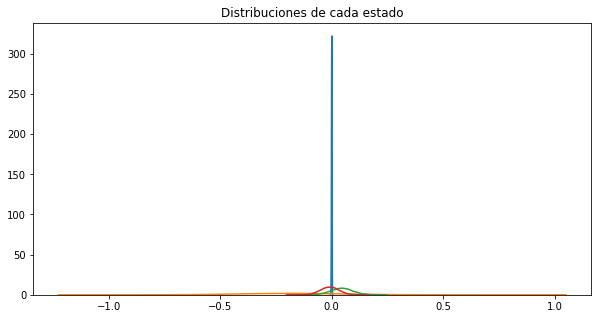

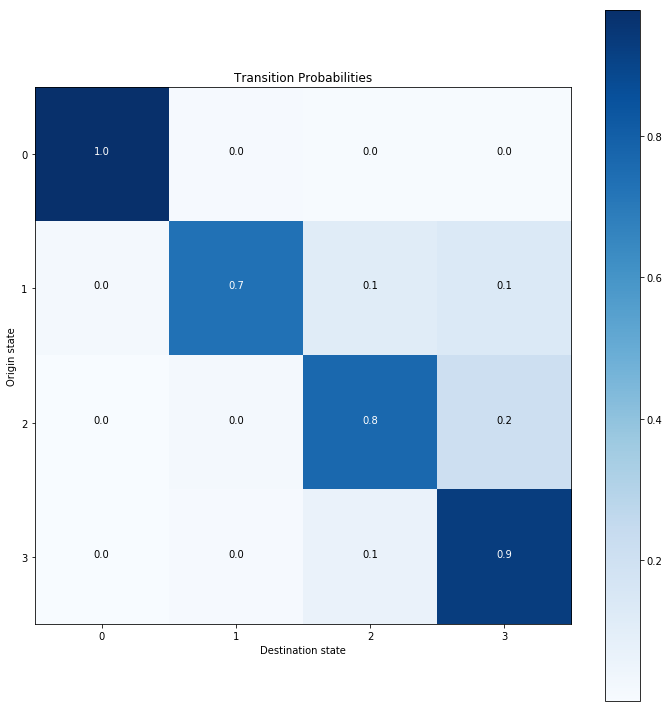

Log-likehood con 8  estados del conjunto de entrenamiento 137568.10301872075


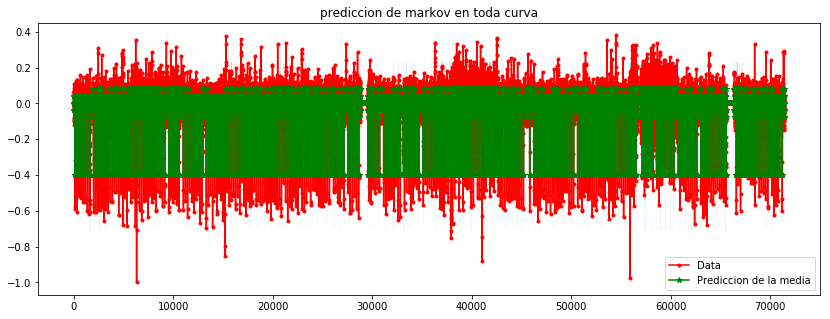

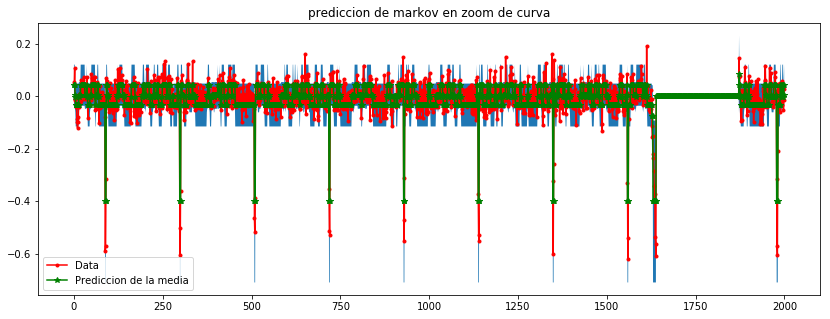

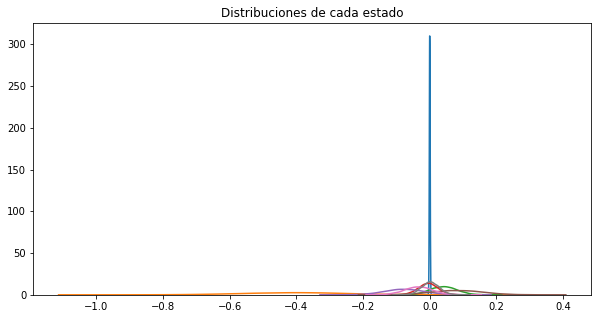

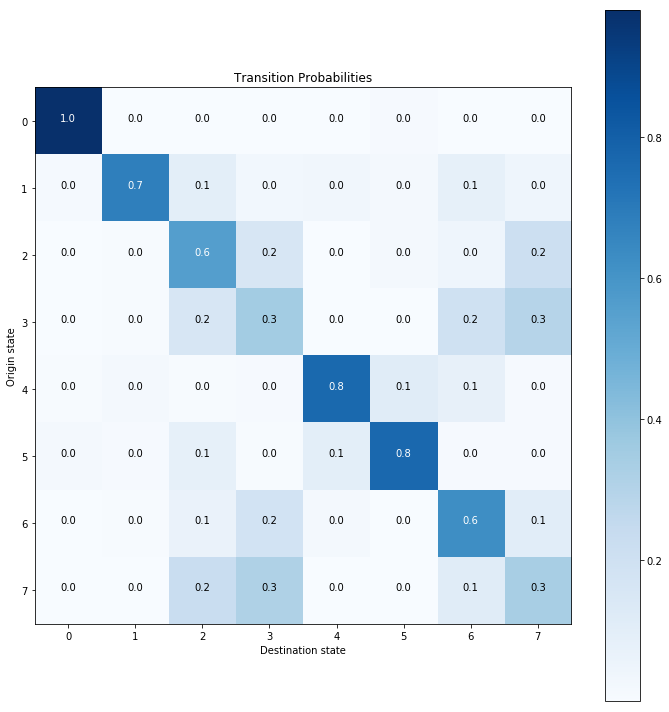

Log-likehood con 16  estados del conjunto de entrenamiento 138905.89644281988


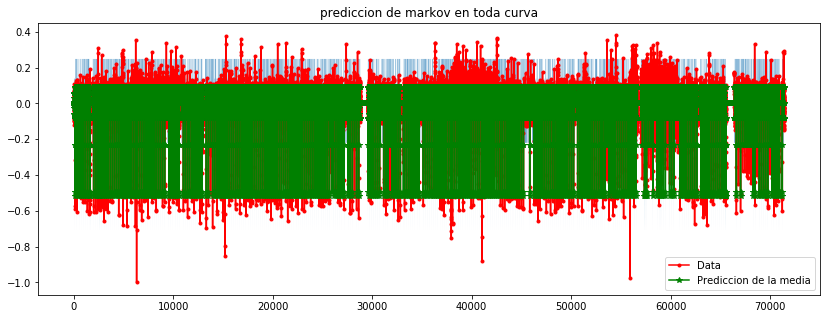

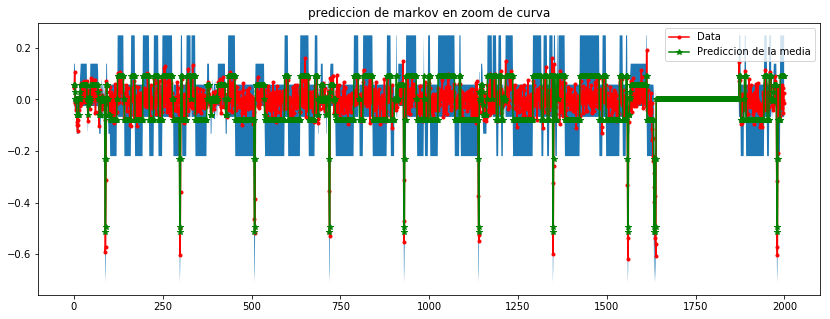

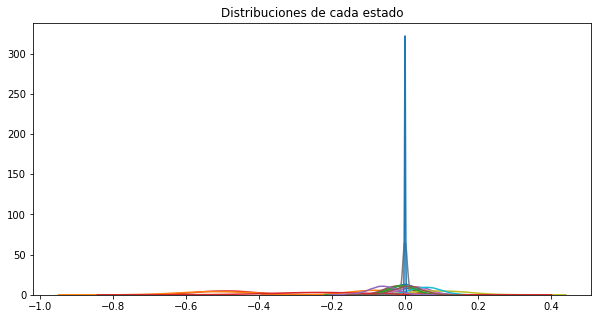

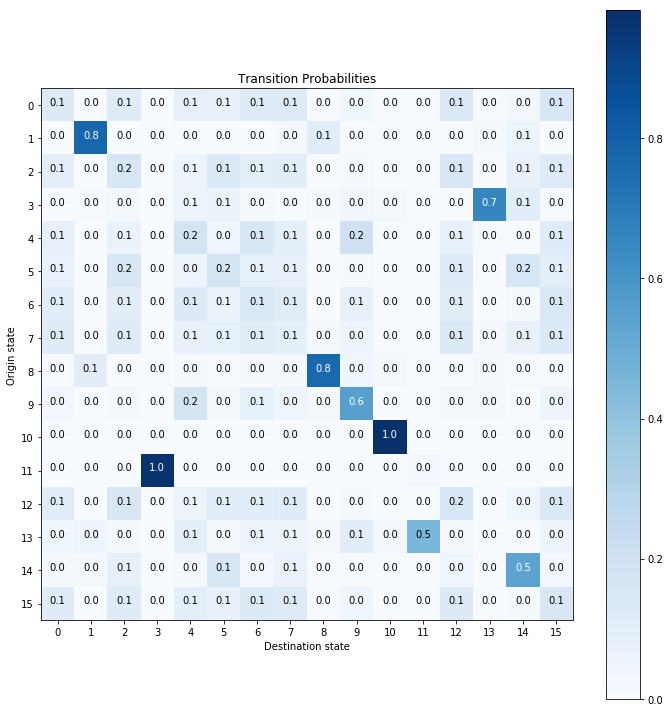

Log-likehood con 32  estados del conjunto de entrenamiento 139608.53827406207


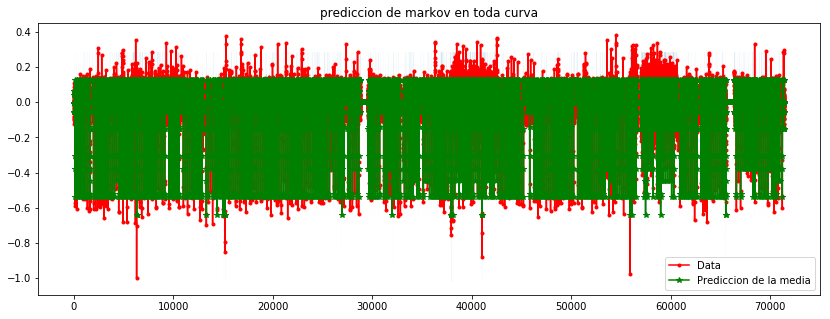

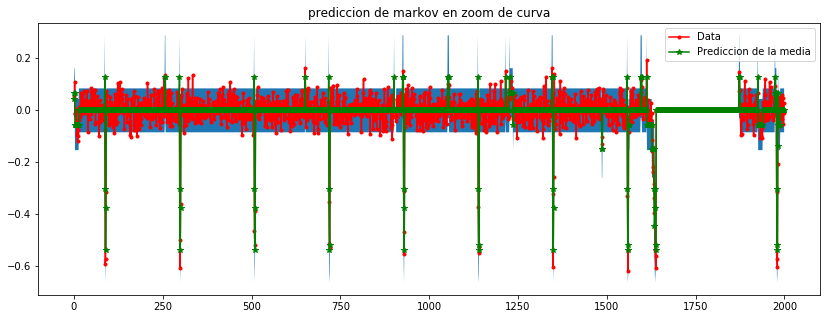

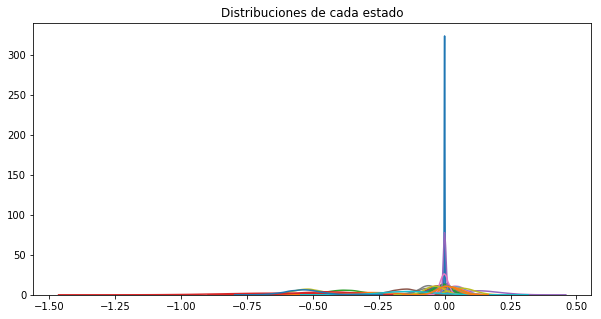

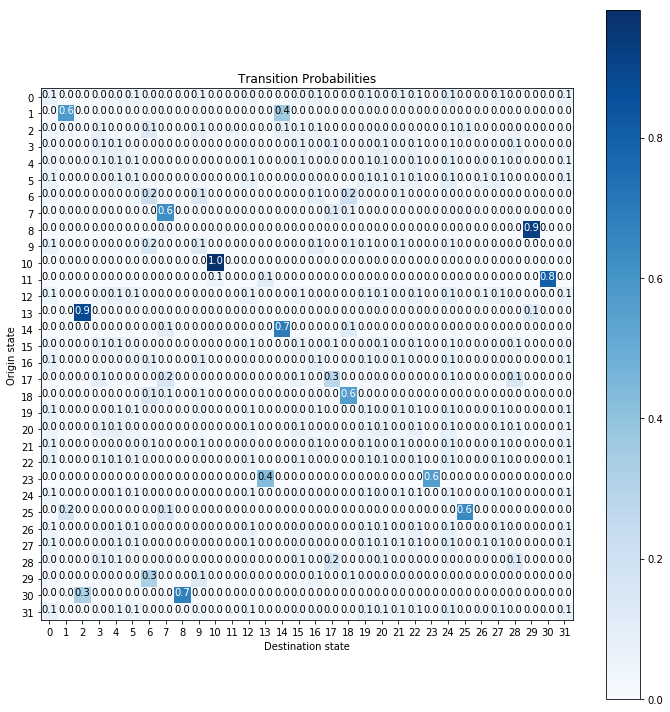

In [ ]:
#n_state = [5,10,20,40]
-

### utilizando tramos

In [72]:
def plot_model_and_data(plot_lc, model, p_n=2000, real_lc=[] ):
    X_state = model.predict(plot_lc) #predice el estado, no el valor 
    X_state_mean = model.means_[X_state][:,0]
    X_state_cov = np.sqrt(model.covars_[X_state][:,0,0])
    if len(real_lc) != 0:
        if len(plot_lc) != len(real_lc):
            mask_nan = np.isnan(real_lc)
            aux = np.tile(np.nan, len(real_lc) )
            
            aux_lc = aux.copy()
            aux_lc[~mask_nan] = np.squeeze(plot_lc)
            plot_lc = aux_lc
            
            aux_X_state_mean = aux.copy()
            aux_X_state_mean[~mask_nan] = X_state_mean
            X_state_mean = aux_X_state_mean
            
            aux_X_state_cov = aux.copy()
            aux_X_state_cov[~mask_nan] = X_state_cov
            X_state_cov = aux_X_state_cov
    plt.figure(figsize=(14,6))
    plt.plot(plot_lc,'r.-',label="Data")
    plt.fill_between(np.arange(len(plot_lc)),
                     X_state_mean-1.96*X_state_cov,
                     X_state_mean+1.96*X_state_cov) 
    plt.plot(X_state_mean,'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov en curva")
    plt.show()
    
    plt.figure(figsize=(14,6))
    plt.plot(plot_lc[:p_n],'r.-',label="Data")
    plt.fill_between(np.arange(p_n),
                     X_state_mean[:p_n]-1.96*X_state_cov[:p_n],
                     X_state_mean[:p_n]+1.96*X_state_cov[:p_n]) 
    plt.plot(X_state_mean[:p_n],'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov zoom en curva")
    plt.show()

In [73]:
lc_wind_nan = []
lengths = []

sublist = []
for value in lc_our_detrend:
    if np.isnan(value) and len(sublist) != 0:
        if len(sublist) == 1: #algo?
            pass
        lc_wind_nan.append(np.asarray(sublist))
        lengths.append(len(sublist))
        sublist = []
    elif np.isnan(value) and len(sublist) == 0:
        continue
    else: #if value not nan
        sublist.append(value) 
lc_wind_nan = np.asarray(lc_wind_nan)   
lengths = np.asarray(lengths)   

print("Cantidad de tramos: ",len(lengths))
print("Largo promedio de tramos: ", np.mean(lengths))
print("Mediana de largo de tramos: ", np.median(lengths))
print("Min de largo de tramos: ", np.min(lengths))
print("Max de largo de tramos: ", np.max(lengths))

Cantidad de tramos:  823
Largo promedio de tramos:  78.228432563791
Mediana de largo de tramos:  76.0
Min de largo de tramos:  1
Max de largo de tramos:  149


In [ ]:
#borrar tramos de largo 1??

In [74]:
lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)

#Al parecer esto es Necesario para amplificar/disminuir escala
lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

lc_wind_nan.shape

(64382, 1)

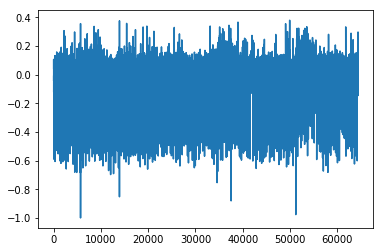

In [75]:
plt.plot(lc_wind_nan[:,0])

Log-likehood con 4  estados del conjunto de entrenamiento 99500.70303707143


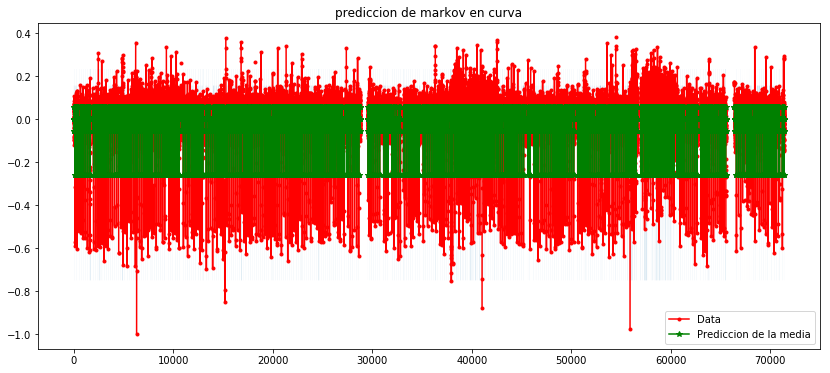

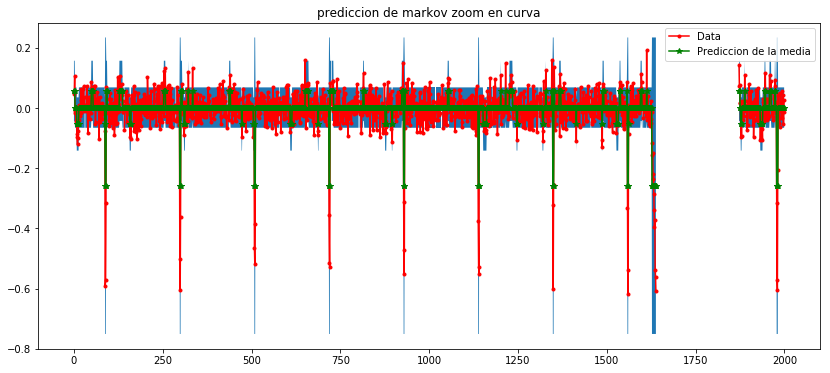

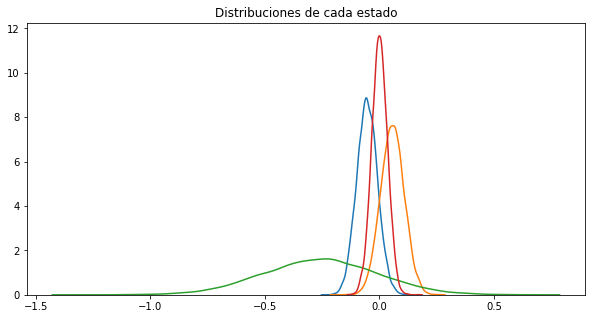

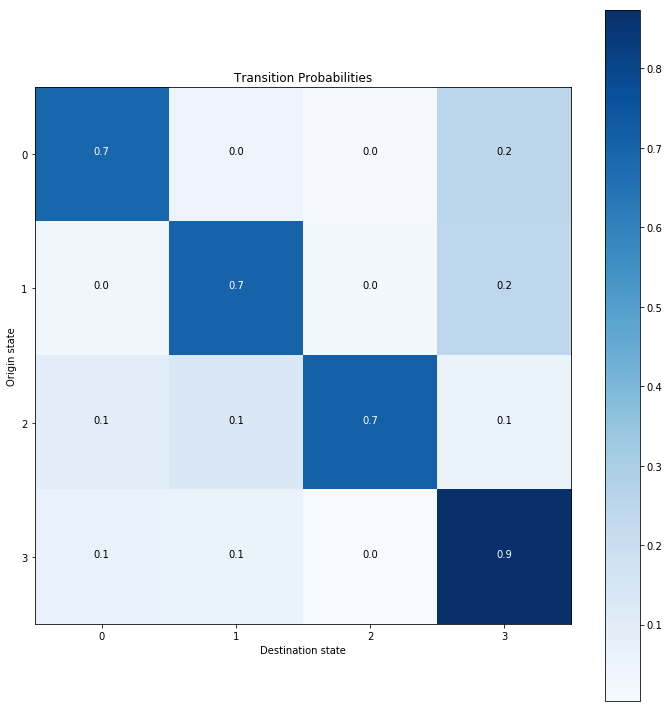

Log-likehood con 8  estados del conjunto de entrenamiento 100712.92795912473


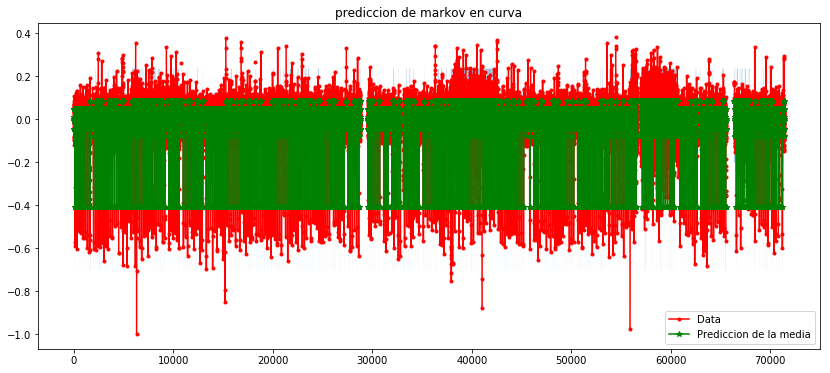

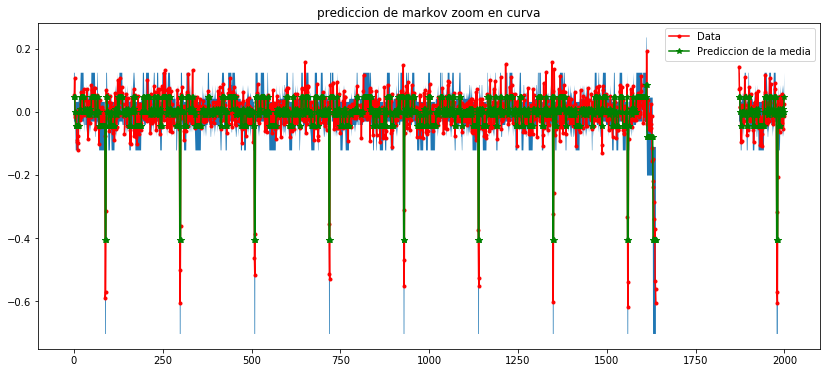

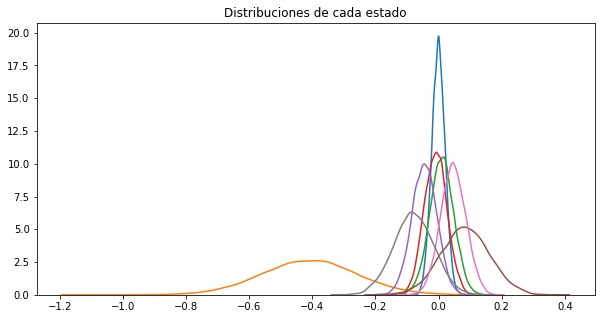

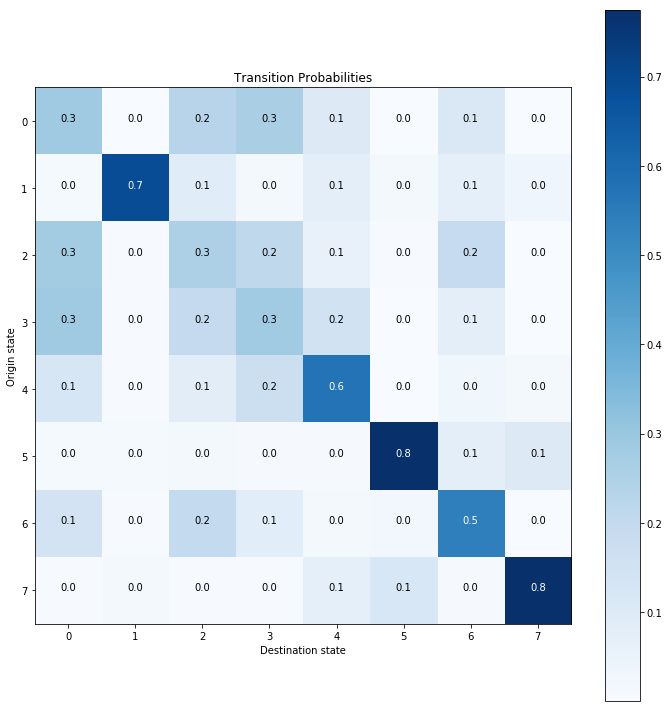

Log-likehood con 16  estados del conjunto de entrenamiento 101201.42829768657


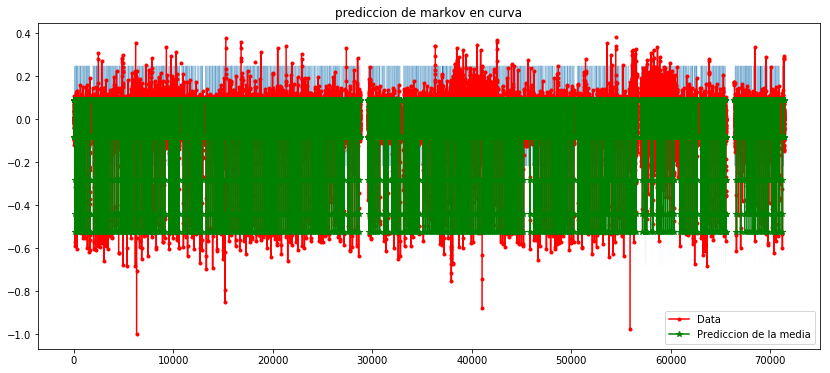

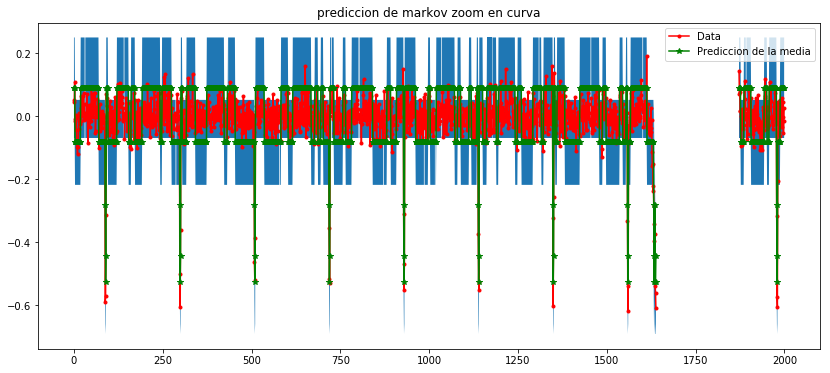

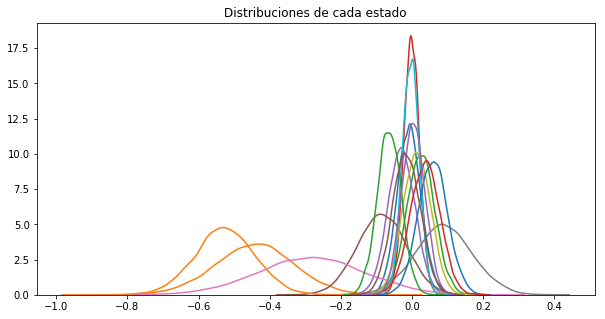

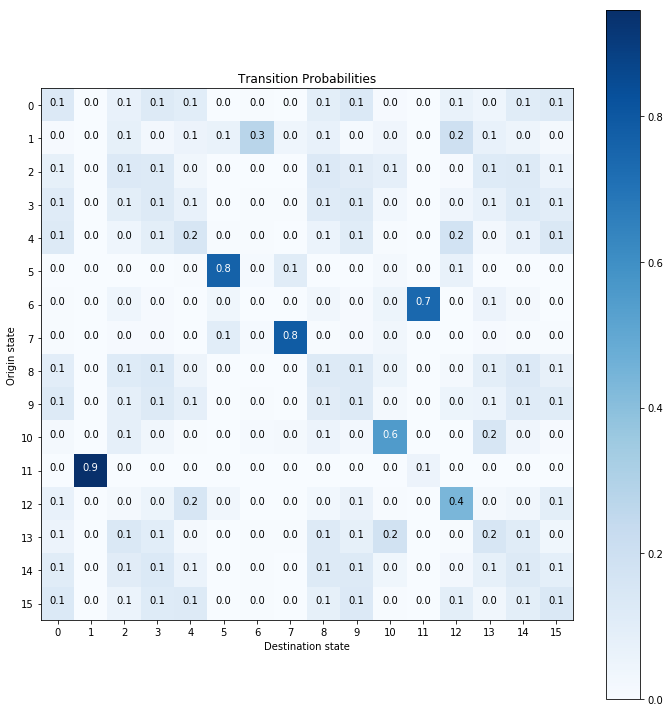

KeyboardInterrupt: 

In [76]:
#n_state = [5,10,20,40]
n_state = [4,8,16,32,64]
for n_sta in n_state:
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(lc_wind_nan , lengths)
    
    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(lc_wind_nan)) 
    
    plot_model_and_data(lc_wind_nan, markov_model, p_n=2000, real_lc= lc_our_detrend) 
    
    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
    plt.show()